In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [2]:
# Load dataset
df = pd.read_csv('cnbc.csv')


In [3]:
# Praproses teks
max_features = 2000  # Jumlah kata yang akan di-tokenisasi
max_len = 300  # Panjang maksimum dari setiap sequence

tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Stem_article'])
X = tokenizer.texts_to_sequences(df['Stem_article'])
X = pad_sequences(X, maxlen=max_len)

# Pastikan label biner
y = df['polarity'].values

In [4]:
# Menggabungkan X dan y untuk memudahkan undersampling
data = pd.DataFrame(X)
data['polarity'] = y

# Pisahkan kelas mayoritas dan minoritas
majority = data[data['polarity'] == 0]
minority = data[data['polarity'] == 1]


In [5]:
# Undersample kelas mayoritas
majority_undersampled = resample(majority,
                                 replace=False,  # Tidak mengganti sampel
                                 n_samples=len(minority),  # Cocokkan jumlah dengan kelas minoritas
                                 random_state=42)  # Untuk reproduktifitas

# Gabungkan kembali kelas mayoritas yang undersampled dengan kelas minoritas
undersampled_data = pd.concat([majority_undersampled, minority])

# Pisahkan kembali X dan y
X = undersampled_data.drop('polarity', axis=1).values
y = undersampled_data['polarity'].values


In [6]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Hyperparameter tuning
def build_model(lstm_units, dropout_rate):
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
        SpatialDropout1D(dropout_rate),
        LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
# Hyperparameter grid
lstm_units_list = [50, 100, 150]
dropout_rate_list = [0.2, 0.3, 0.4]
batch_size_list = [32, 64]
epochs = 10

best_accuracy = 0
best_params = None
history_dict = {}

In [9]:
for lstm_units in lstm_units_list:
    for dropout_rate in dropout_rate_list:
        for batch_size in batch_size_list:
            print(f"Training model with LSTM units: {lstm_units}, Dropout rate: {dropout_rate}, Batch size: {batch_size}")
            model = build_model(lstm_units, dropout_rate)
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)
            score = model.evaluate(X_test, y_test, verbose=0)
            accuracy = score[1]
            print(f"Accuracy: {accuracy}")

            # Save the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (lstm_units, dropout_rate, batch_size)
                history_dict = history.history

print(f"Best hyperparameters - LSTM units: {best_params[0]}, Dropout rate: {best_params[1]}, Batch size: {best_params[2]}")
print(f"Best accuracy: {best_accuracy}")

Training model with LSTM units: 50, Dropout rate: 0.2, Batch size: 32


c:\Users\Anjelita Malik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
26/26 - 9s - 336ms/step - accuracy: 0.5327 - loss: 0.6902 - val_accuracy: 0.5714 - val_loss: 0.6826
Epoch 2/10
26/26 - 4s - 147ms/step - accuracy: 0.7300 - loss: 0.6115 - val_accuracy: 0.6158 - val_loss: 0.6673
Epoch 3/10
26/26 - 6s - 218ms/step - accuracy: 0.8126 - loss: 0.4687 - val_accuracy: 0.6305 - val_loss: 0.6558
Epoch 4/10
26/26 - 5s - 204ms/step - accuracy: 0.8705 - loss: 0.3443 - val_accuracy: 0.6601 - val_loss: 0.6801
Epoch 5/10
26/26 - 6s - 231ms/step - accuracy: 0.8977 - loss: 0.2815 - val_accuracy: 0.6847 - val_loss: 0.7545
Epoch 6/10
26/26 - 10s - 402ms/step - accuracy: 0.8631 - loss: 0.3373 - val_accuracy: 0.6404 - val_loss: 0.7309
Epoch 7/10
26/26 - 4s - 167ms/step - accuracy: 0.9199 - loss: 0.2417 - val_accuracy: 0.6404 - val_loss: 0.7473
Epoch 8/10
26/26 - 5s - 203ms/step - accuracy: 0.9273 - loss: 0.1887 - val_accuracy: 0.6700 - val_loss: 0.8084
Epoch 9/10
26/26 - 6s - 221ms/step - accuracy: 0.9531 - loss: 0.1532 - val_accuracy: 0.6552 - val_loss: 0.8748


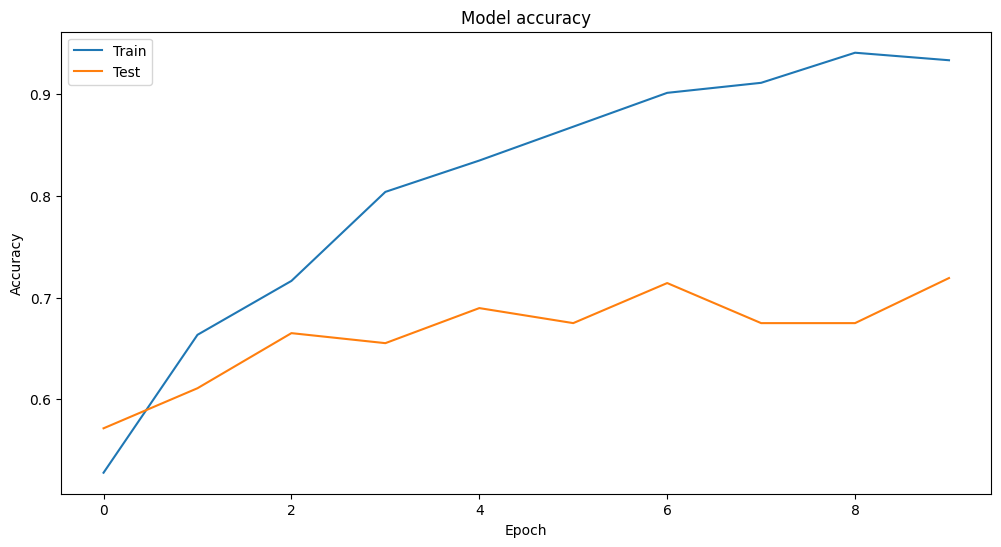

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


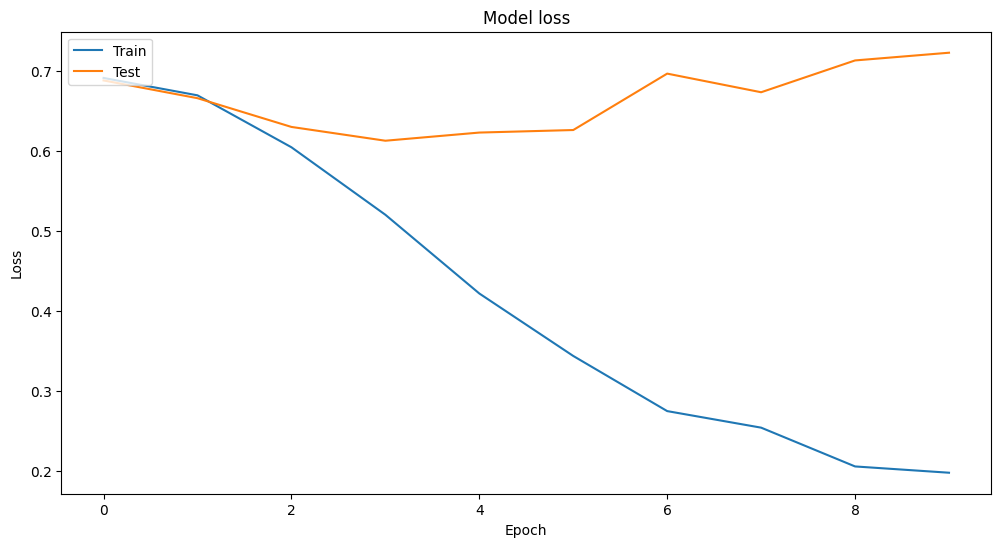

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# Evaluasi model terbaik
model = build_model(*best_params[:2])
model.fit(X_train, y_train, epochs=epochs, batch_size=best_params[2], validation_data=(X_test, y_test), verbose=2)
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]}')
print(f'Accuracy: {score[1]}')


Epoch 1/10
13/13 - 6s - 484ms/step - accuracy: 0.5339 - loss: 0.6909 - val_accuracy: 0.5567 - val_loss: 0.6878
Epoch 2/10
13/13 - 3s - 238ms/step - accuracy: 0.6917 - loss: 0.6707 - val_accuracy: 0.6108 - val_loss: 0.6681
Epoch 3/10
13/13 - 3s - 201ms/step - accuracy: 0.7337 - loss: 0.5885 - val_accuracy: 0.6601 - val_loss: 0.6222
Epoch 4/10
13/13 - 3s - 196ms/step - accuracy: 0.8039 - loss: 0.4791 - val_accuracy: 0.6749 - val_loss: 0.6185
Epoch 5/10
13/13 - 3s - 196ms/step - accuracy: 0.8471 - loss: 0.4015 - val_accuracy: 0.6749 - val_loss: 0.6218
Epoch 6/10
13/13 - 4s - 320ms/step - accuracy: 0.8853 - loss: 0.3343 - val_accuracy: 0.6502 - val_loss: 0.6505
Epoch 7/10
13/13 - 3s - 227ms/step - accuracy: 0.8952 - loss: 0.3106 - val_accuracy: 0.6601 - val_loss: 0.6876
Epoch 8/10
13/13 - 3s - 195ms/step - accuracy: 0.9088 - loss: 0.2509 - val_accuracy: 0.6355 - val_loss: 0.7557
Epoch 9/10
13/13 - 3s - 205ms/step - accuracy: 0.9162 - loss: 0.2523 - val_accuracy: 0.6404 - val_loss: 0.7388
E

In [13]:
# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Evaluasi hasil prediksi
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
[[57 39]
 [22 85]]
              precision    recall  f1-score   support

           0       0.72      0.59      0.65        96
           1       0.69      0.79      0.74       107

    accuracy                           0.70       203
   macro avg       0.70      0.69      0.69       203
weighted avg       0.70      0.70      0.70       203



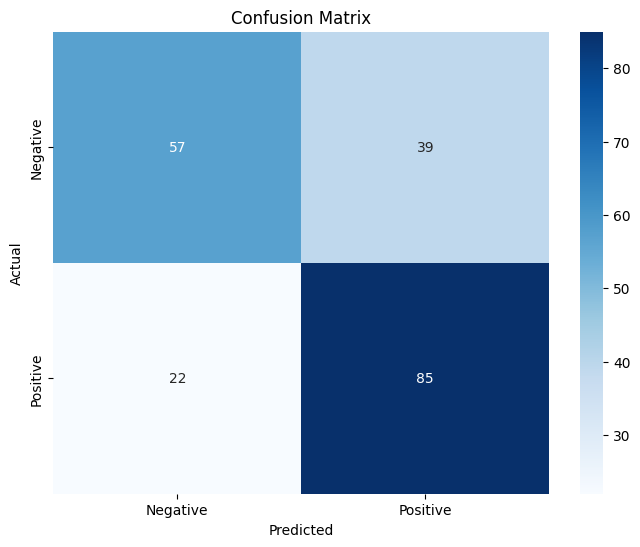

In [14]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()